<a href="https://colab.research.google.com/github/daniilwithangelic/laba-in-car-obychen/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 4: Задача классификации

## **Цель занятия:**
Изучить задачу классификации, познакомиться с метриками качества, реализовать классификатор с использованием разных моделей.

## **Задание состоит из следующих частей:**
1. Отбор признаков
2. Обучение классификатора
3. Обработка "переобучения" и дисбаланс классов и как с этим жить
4. Метирки качества и что это все означает
5. Задача мультиклассовой классификации
6. Дерево принятия решений

# ⏰ Домашнее задание

- 1. Выбрать пременную для задачи бинарной классификации (назовем это x_binary, y_binary) и выбрать пременные для задачи мультиклассовой классификации (назовем это x_multi, y_multi)

p.s. если использовали произвольную пременную для binary, multiclassification - не зывбаем выбрасывать из X изначальную переменную

- 2. Решить задачу классификации с использованием кросс валидации, оценить метрики качства: accuracy, precision, recall (включая classification report).
  - 2.1. Используя опыт прошлых работ, попробуйте использовать лучшие признаки для решения задачи

- 3. Для обоих задач побороться с дисбалансом классов следующими техниками:
  - oversampling (например, SMOTE)
  - или undersampling.

Для oversampling и undersampling используйте (https://imbalanced-learn.org/)
Опишите полученный результат

Самый простой пример (желательно не использовать рандом)
```
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
```

- 4. Обучить дерево принятия решений с использованием кросс-валидации (Stratify K-fold и/или StratifyRandomShuffle)  для ```oversampling``` и ```undersampling``` (в задачи мультиклассовой классификации), оценить метрики и описать результат.



## 1: Загрузка библиотек и предобратка данных

In [3]:
!pip install pandas scikit-learn seaborn scipy

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/income.csv')

df['is_work'] = np.where(df['hours-per-week'] >= 35, 1, 0)
df.is_work = df.is_work.astype('category')
df['education-num'] = df['education-num'].astype('category')

y = df['is_work'] # выбираем целевую переменную (категориальную)
X = df.drop('is_work', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('hours-per-week', axis=1)
df.drop('hours-per-week', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       30725 non-null  object  
 2   education       32561 non-null  object  
 3   education-num   32561 non-null  category
 4   marital-status  32561 non-null  object  
 5   occupation      30718 non-null  object  
 6   relationship    32561 non-null  object  
 7   race            32561 non-null  object  
 8   sex             32561 non-null  object  
 9   capital-gain    32561 non-null  int64   
 10  capital-loss    32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
 13  is_work         32561 non-null  category
dtypes: category(2), int64(4), object(8)
memory usage: 3.0+ MB


In [5]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


### 1.2 Проверка баланса

Проверка, насколько сбалансированы классы в нашей целевой переменной:

In [6]:
y.value_counts()

,count
is_work,
1,26978
0,5583


количество часов неделю не очень хорошо сболансированы, так как большенство людей работают от 35 часов в неделю, а те кто работаю меньше 35 часов в неделю, таких люде меньше из-за этого не очень сбалонсированно

### 1.3 Создание искусственного дисбаланса классов
Создадим новую целевую переменную y_disbalanced, где 90% классов будут 0, а 10% — 1:

In [7]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
majority = data[data['is_work'] == 0]
minority = data[data['is_work'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('is_work', axis=1)
y_disbalanced = data_disbalanced['is_work']




Проверим новый баланс классов:

In [8]:
print(y_disbalanced.value_counts())


is_work
0    5583
1     558
Name: count, dtype: int64


Теперь стало на оборот

###1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе

In [9]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

# # Разделяем данные на обучающую и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# # Обучаем модель
# model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
# model.fit(X_train, y_train)

# # Предсказания
# y_pred = model.predict(X_test)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Применяем One-Hot Encoding к категориальным переменным
X_disbalanced_encoded = pd.get_dummies(X_disbalanced, drop_first=True)

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced_encoded, y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель с использованием L2 регуляризации
model = LogisticRegression(penalty='l2', solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Вывод результатов
print("Predictions:", y_pred)


Predictions: [0 0 0 ... 0 0 0]


In [10]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9066739012479653

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      1671
           1       0.00      0.00      0.00       172

    accuracy                           0.91      1843
   macro avg       0.45      0.50      0.48      1843
weighted avg       0.82      0.91      0.86      1843



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Мы видим что модель в классе 0 смогла определить правильно на 91% в дисбалансном режиме, а класс 1 вообще не смогла определить
Мы видим, что все наблюдение которые были даны класса 0 было правильно определен, а для класса 1 не смогла обнружить какие либо наблюдения у класса 1

Мы делаем вывод, что в среднем модель показывает плохую производительно по следующим параметрам:

Precision (Точность): 0.45

Recall (Вспомнить): 0.50

F1-score (F1-счет): 0.48

In [11]:


unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{0: 1843}

### 1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое

In [12]:
# # Уменьшаем количество экземпляров класса 0
# majority_downsampled = resample(majority,
#                                 replace=False,
#                                 n_samples=len(minority),
#                                 random_state=42)

# # Объединяем обратно
# data_balanced = pd.concat([majority_downsampled, minority])

# # Новые X и y
# X_balanced = data_balanced.drop('is_work', axis=1)
# y_balanced = data_balanced['is_work']

from sklearn.utils import resample

# Предполагаем, что majority и minority уже определены
# Проверяем количество экземпляров
n_majority = len(majority)
n_minority = len(minority)

# Уменьшаем количество экземпляров класса 0, но не превышаем их количество
n_samples = min(n_majority, n_minority)

# Уменьшаем количество экземпляров класса 0
majority_downsampled = resample(majority,
                                 replace=False,
                                 n_samples=n_samples,
                                 random_state=42)

# Объединяем обратно
data_balanced = pd.concat([majority_downsampled, minority])

# Новые X и y
X_balanced = data_balanced.drop('is_work', axis=1)
y_balanced = data_balanced['is_work']


In [13]:
print(y_balanced.value_counts())


is_work
1    26978
0     5583
Name: count, dtype: int64


In [14]:
print(X_balanced.columns)



Index(['age', 'workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'native-country', 'income >50K', 'education-num_2', 'education-num_3',
       'education-num_4', 'education-num_5', 'education-num_6',
       'education-num_7', 'education-num_8', 'education-num_9',
       'education-num_10', 'education-num_11', 'education-num_12',
       'education-num_13', 'education-num_14', 'education-num_15',
       'education-num_16'],
      dtype='object')


In [15]:
# # Разделяем данные
# X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# # Обучаем модель
# model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
# model_balanced.fit(X_train_bal, y_train_bal)

# # Предсказания
# y_pred_bal = model_balanced.predict(X_test_bal)
# from imblearn.over_sampling import SMOTE

# # Убедитесь, что y является категориальным
# y = y.astype('category')

# # Применение One-Hot Encoding
# X = pd.get_dummies(X, drop_first=True)

# # Преобразование всех столбцов в числовые
# X = X.astype(float)

# # Проверка на наличие классов в y
# if y.nunique() < 2:
#     raise ValueError("Целевая переменная должна содержать как минимум два класса.")

# # Балансировка классов с использованием SMOTE
# smote = SMOTE(random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X, y)

# # Разделяем данные
# X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# # Обучаем модель с корректным значением penalty
# model_balanced = LogisticRegression(penalty='l2', solver='saga', max_iter=10000)

# # Проверка размеров данных перед обучением
# print("Размеры обучающего набора:", X_train_bal.shape, y_train_bal.shape)
# print("Размеры тестового набора:", X_test_bal.shape, y_test_bal.shape)

# # # Обучаем модель
# model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
# model_balanced.fit(X_train_bal, y_train_bal)

# # Предсказания
# try:
#     y_pred_bal = model_balanced.predict(X_test_bal)
#     print("Предсказания выполнены.")
# except Exception as e:
#     print("Ошибка при выполнении предсказаний:", e)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Убедитесь, что y является категориальным
y = y.astype('category')

# Применение One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

# Проверка на наличие классов в y
if y.nunique() < 2:
    raise ValueError("Целевая переменная должна содержать как минимум два класса.")

# Балансировка классов с использованием SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель с корректным значением penalty
model_balanced = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)  # Используем 'liblinear' для быстроты

# Проверка размеров данных перед обучением
print("Размеры обучающего набора:", X_train_bal.shape, y_train_bal.shape)
print("Размеры тестового набора:", X_test_bal.shape, y_test_bal.shape)

# Обучаем модель
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
try:
    y_pred_bal = model_balanced.predict(X_test_bal)
    print("Предсказания выполнены.")
except Exception as e:
    print("Ошибка при выполнении предсказаний:", e)


Размеры обучающего набора: (37769, 110) (37769,)
Размеры тестового набора: (16187, 110) (16187,)
Предсказания выполнены.


In [16]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))


Accuracy: 0.8328288132451968

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      7996
           1       0.85      0.82      0.83      8191

    accuracy                           0.83     16187
   macro avg       0.83      0.83      0.83     16187
weighted avg       0.83      0.83      0.83     16187



Когда сделали сбалансированную выборку, то статиски стала на много лучше

Для класса 0 было хуже предсказана в сбалансировоной моделе, чем в десбалансированной на 9%
а для класса 1 стала лучше предсказывать на 85%

по наблюдение мы можем сказать, что точность стала лучше для класса 1 на 82%, а для класса 0 стала хуже на 15%

Самма модель мы можем сказать что стала сбалансирована причем для обоих моделей по следующим пораметрам

Precision: 0.83

Recall: 0.83

F1-score: 0.83

Weighted avg

In [17]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 8284, 1: 7903}

In [18]:
# # Выбираем числовые признаки
# numeric_features = X_balanced.select_dtypes(include=['float64']).columns.tolist()

# # Инициализируем scaler
# scaler = MinMaxScaler()

# # Применяем нормализацию
# X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])

from sklearn.preprocessing import MinMaxScaler

# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64', 'int']).columns.tolist()

# Проверяем, есть ли числовые признаки
if not numeric_features:
    raise ValueError("Нет числовых признаков для нормализации.")

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
try:
    X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])
    print("Нормализация выполнена успешно.")
except Exception as e:
    print("Ошибка при нормализации:", e)



Нормализация выполнена успешно.


In [19]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [20]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # Дополнительно получили 1.57% точности, отлично!


Accuracy: 0.8362883795638475

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      7996
           1       0.85      0.82      0.84      8191

    accuracy                           0.84     16187
   macro avg       0.84      0.84      0.84     16187
weighted avg       0.84      0.84      0.84     16187



После того как попытались улучшить результат модели, мы видим, что модель стало не значительно но лучше предсказывать, процент точности вырас на 1%, если смотреть в целом, а если смотреть детально, то нет каких-то значительных улучшений

In [21]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 8236, 1: 7951}

# 2 Метрики качества классификаци

Приведу разбор метрик классификации с аналогиями, используя пример с яблоками разных цветов 🍏🍎. Представьте, что задача — правильно определить, какие яблоки зеленые, красные или желтые. Каждая метрика поможет оценить, насколько хорошо мы справляемся с этой задачей.

То есть, есть Y, который состоит из яблок разных цветов
- 1 🍏 - класс 0
- 2 🍎 - класс 1

Прежде чем перейти к метрикам, важно понять, что означают обозначения TP, FP, TN, FN. Они представляют разные типы предсказаний:

- TP (True Positive) — правильно предсказанные положительные примеры (например, если мы верно определили 🍏 как зеленое яблоко).

- FP (False Positive) — ошибочно предсказанные положительные примеры (например, если мы предсказали 🍎 как 🍏).

- TN (True Negative) — правильно предсказанные отрицательные примеры (например, если мы верно определили, что 🍎 не является 🍏).

- FN (False Negative) — ошибочно предсказанные отрицательные примеры (например, если мы не определили 🍏 как зеленое яблоко, хотя оно таким является).

Положительные предсказание:
TP (истоное **положительное предсказание**) - Верное предсказание (верное определение, что 🍏 это 🍏 )

FP (ложное **положительное предсказание**) -Ложное предсказование (предсказала, что 🍏 это 🍎)

Отрицательные предсказания:
TN (истиное **отрицательное предсказание**) - Истино предсказывает, например что 🍏 это не 🍎

FN (ложное **отрицательное предсказание**) - Ложно предсказывает, что 🍏 это не зеленое яблоко

### 2.1 Точность (Accuracy)


Формула:
Accuracy = (TP + TN) / (TP + FP + TN + FN)

Пример:
У нас 10 яблок: 4 🍏, 3 🍎, 3 🍊. Алгоритм правильно предсказал 7 из них.
Accuracy = 7 / 10 = 0.7 или 70%

**Когда использовать**:
Точность полезна, когда классы сбалансированы (примерно равное количество примеров каждого типа). В случаях сильного дисбаланса классов, точность может стать вводящей в заблуждение, так как она не учитывает, что какой-то класс может преобладать.

### 2.2 Precision и Recall

- Precision (Точность) — процент верных положительных предсказаний среди всех предсказанных положительных.
- Recall (Полнота) — процент верных положительных предсказаний среди всех фактических положительных случаев.

Формулы:
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

Пример:
Мы пытаемся предсказать 🍏 (зеленое яблоко).

У нас 5 🍏, из них 4 правильно определены как 🍏, но 1 🍎 ошибочно классифицировано как 🍏.
- Precision для 🍏: 4 / (4 + 1) = 0.8 или 80%
- Recall для 🍏: 4 / (4 + 1) = 0.8 или 80%

**Когда использовать**:

Precision важен, когда критично избежать ложных положительных предсказаний (например, если ошибочно отнесенные яблоки могут повлиять на качество товара).
Recall важен, когда критично найти все положительные примеры (например, если требуется найти все 🍏 в ящике, чтобы их не упустить).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" height=800 />

### 2.3. F1-score


F1-score — это гармоническое среднее между Precision и Recall, что позволяет учитывать как ложноположительные, так и ложноотрицательные предсказания.

Формула:
- F1 = 2 * (Precision * Recall) / (Precision + Recall)

Пример:

Если Precision = 80% и Recall = 80%, то:
F1 = 2 * (0.8 * 0.8) / (0.8 + 0.8) = 0.8 или 80%

**Когда использовать**:
F1-score полезен, когда требуется балансировать между Precision и Recall, особенно при наличии дисбаланса классов. Он важен, когда критично учитывать и ложные положительные, и ложные отрицательные предсказания.

### 2.4. ROC-AUC
ROC-кривая показывает, как меняется соотношение между True Positive Rate (доля правильно предсказанных положительных) и False Positive Rate (доля ошибочно предсказанных положительных) при разных порогах. AUC (площадь под ROC-кривой) измеряет общую способность модели различать классы.

Когда использовать:
ROC-AUC используется для оценки моделей, когда требуется понять способность модели различать классы в задаче классификации. Чем ближе AUC к 1, тем лучше модель. AUC особенно полезен, когда классы несбалансированы, так как он показывает общую производительность модели при разных порогах.

ROC-кривая (Receiver Operating Characteristic) отображает зависимость между:

- True Positive Rate (TPR) — это доля правильно предсказанных положительных примеров среди всех фактических положительных примеров.
Формула: TPR = TP / (TP + FN)

- False Positive Rate (FPR) — это доля ошибочно предсказанных положительных примеров среди всех фактических отрицательных примеров.
Формула: FPR = FP / (FP + TN)

На графике ROC:

- Ось Y представляет TPR (доля верных положительных предсказаний).
- Ось X представляет FPR (доля ошибочных положительных предсказаний).

AUC (Area Under Curve) — это площадь под ROC-кривой. Она измеряет способность модели различать классы: чем больше площадь (чем ближе AUC к 1), тем лучше модель справляется с разделением классов.

- AUC = 1 — идеальная модель: она всегда отличает положительный класс от отрицательного.
- AUC = 0.5 — случайное угадывание, модель не способна различать классы лучше, чем просто случайный выбор.

[Подробнее](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=ru)

### 2.5 Classification Report

### Classification Report (на примере 🍏 и 🍎):

|               | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| **0 (🍏)**    | 0.78      | 0.73   | 0.75     | 390     |
| **1 (🍎)**    | 0.74      | 0.79   | 0.76     | 377     |
| **Accuracy**  |           |        | 0.76     | 767     |
| **Macro avg** | 0.76      | 0.76   | 0.76     | 767     |
| **Weighted avg** | 0.76   | 0.76   | 0.76     | 767     |

---

1. **Precision**:
   - **🍏 (0.78)** — 78% предсказанных 🍏 действительно 🍏.
   - **🍎 (0.74)** — 74% предсказанных 🍎 действительно 🍎.

2. **Recall**:
   - **🍏 (0.73)** — модель нашла 73% всех 🍏.
   - **🍎 (0.79)** — модель нашла 79% всех 🍎.

3. **F1-score**:
   - **🍏 (0.75)**, **🍎 (0.76)** — баланс Precision и Recall для каждого класса.

4. **Accuracy** = 0.76 — 76% всех предсказаний правильны.


### 2.6 А теперь до делу (вернемся к прошлым примерам и проанализуем нашу ситуацию)

In [22]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}


⏰ оцениваем метрики и объясняем результат (без ChatGPT)

In [24]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      7996
           1       0.85      0.82      0.84      8191

    accuracy                           0.84     16187
   macro avg       0.84      0.84      0.84     16187
weighted avg       0.84      0.84      0.84     16187



0🍏Класс пердсказан на 82% точно, на 85% правильно классифицировала наблюдения которые были данны, сболансированна на 84% для этого класса

1🍎Класс пердсказан на 85% точно, на 82% правильно классифицировала наблюдения которые были данны, сболансированна на 84% для этого класса

Если смотреть в целом, то это хорошая сболансированная модель (на 84%)

Это мы определили по следующим метрика:

Precision (точность): 0.84

Recall (вспомнить): 0.84

F1-score (F1-отчет): 0.84

Weighted avg (Взвешенное среднее значение): 0.84

In [25]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[6791, 1205],
       [1445, 6746]])

6791 - это предсказание через отрицание (истино), 1205 - положительнео предсказание (ложное)

1445 - это предсказание через отрицание (ложное), 6746 - положительнео предсказание (истино)


**Положительные предсказание**:

TP (истоное положительное предсказание) - Верное предсказание (верное определение, что 🍏 это 🍏 )

FP (ложное положительное предсказание) -Ложное предсказование (предсказала, что 🍏 это 🍎)

**Отрицательные предсказания**:

TN (истиное отрицательное предсказание) - Истино предсказывает, например что 🍏 это не 🍎

FN (ложное отрицательное предсказание) - Ложно предсказывает, что 🍏 это не зеленое яблоко

In [26]:
rounded_items

{'True Negatives (TN)': 6791,
 'False Positives (FP)': 1205,
 'False Negatives (FN)': 1445,
 'True Positives (TP)': 6746,
 'Accuracy': 0.84,
 'Precision': 0.85,
 'Recall': 0.82,
 'F1-score': 0.84,
 'ROC-AUC': 0.84}

# 3. Задача мультиклассовой классфикации

Задача мультиклассовой классификации - когда мы хотим предсказать сразу несколько классов

В качестве y - используем hours-per-week (время работы в неделю)

In [27]:
y = df['hours-per-week']

X = df.drop(['hours-per-week', 'is_work'], axis=1)

In [28]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [29]:
X

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,...,education-num_7,education-num_8,education-num_9,education-num_10,education-num_11,education-num_12,education-num_13,education-num_14,education-num_15,education-num_16
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,...,False,False,False,False,False,False,True,False,False,False
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,...,False,False,False,False,False,False,True,False,False,False
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,...,False,False,True,False,False,False,False,False,False,False
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,...,True,False,False,False,False,False,False,False,False,False
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,...,False,False,False,False,False,True,False,False,False,False
32557,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,...,False,False,True,False,False,False,False,False,False,False
32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,0,0,...,False,False,True,False,False,False,False,False,False,False
32559,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,...,False,False,True,False,False,False,False,False,False,False


## 3.1 Алгоритм дерева принятия решений

Алгоритм дерева принятия решений (Decision Tree) — это один из методов машинного обучения, который используется для решения задач классификации и регрессии. Дерево решений представляет собой структуру, в которой каждый внутренний узел соответствует некоторому признаку, а каждая ветвь — определенному значению этого признака. Листовые узлы представляют собой классы или значения, которые необходимо предсказать.

### Как работает дерево решений:

1. **Корневой узел**: Это первый узел в дереве, который соответствует самому информативному признаку. Признак выбирается на основе критериев, например по индексу Gini (различие по y, чем ближе к 1, тем разнороднее классы y в узле)

2. **Разбиение данных**: На каждом шаге дерево разбивает данные на подмножества в соответствии с выбранным признаком. Эти разбиения происходят рекурсивно, пока не будет достигнут некоторый критерий остановки (например, максимальная глубина дерева, минимальное количество данных в листе).

3. **Листовые узлы**: Листовые узлы содержат финальные предсказания. В случае задачи классификации это будет класс, а в случае регрессии — числовое значение.

4. **Критерии остановки**: Дерево останавливает разбиение, если достигается один из критериев остановки — например, если достигнута максимальная глубина дерева или в узле осталось меньше минимального числа данных для разбиения.

### Преимущества:
- Простота визуализации и интерпретации.
- Может использоваться как для классификации, так и для регрессии.
- Не требует предварительной нормализации данных.

### Недостатки:
- Может переобучаться (overfitting), если не ограничить глубину дерева.
- Чувствительно к небольшим изменениям в данных.

In [30]:
# from sklearn.tree import DecisionTreeClassifier
# # Разделяем данные
# X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# # Обучаем модель
# tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
# tree_model.fit(X_train_multi, y_train_multi)

# # Предсказания
# y_pred_multi = tree_model.predict(X_test_multi)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Предполагаем, что X и y уже определены
# Применяем One-Hot Encoding к категориальным переменным
category_columns = X.select_dtypes(include=['object']).columns  # выбираем категориальные колонки
X_encoded = pd.get_dummies(X, columns=category_columns, drop_first=True)

# Разделяем данные на обучающую и тестовую выборки
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)




In [31]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))



Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         9
           4       1.00      0.05      0.09        21
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00         3
          10       0.27      0.07      0.11        83
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00        13
          15       0.04      0.01      0.01       131
          16       0.15      0.03      0.04        76
          17       0.00      0.00      0.00         5
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Про *macro avg* и *weighted avg*.:

1. **Macro average (macro avg)**:
   - Этот показатель вычисляется как среднее арифметическое по каждому классу для всех метрик (precision, recall и f1-score). То есть сначала вычисляются precision, recall и f1-score для каждого класса, а затем они усредняются без учёта того, сколько примеров было в каждом классе. Этот показатель полезен, когда интересует равное внимание к каждому классу, независимо от его частоты в данных.
   - *Проблема*: Если классы несбалансированы (т.е. некоторые классы имеют намного больше примеров, чем другие), то этот показатель может быть искажен в сторону меньших классов.

2. **Weighted average (weighted avg)**:
   - Этот показатель тоже вычисляется на основе метрик каждого класса (precision, recall и f1-score), но с учетом количества примеров (support) в каждом классе. То есть каждый класс вносит свой вклад в среднее значение пропорционально его количеству примеров в данных.
   - *Преимущество*: В отличие от macro avg, weighted avg корректнее отражает общую производительность модели на несбалансированных данных, так как учитывает частоту каждого класса.

Проще говоря:
- **Macro avg** показывает усреднённое качество модели по всем классам, не обращая внимания на то, сколько примеров в каждом классе.
- **Weighted avg** взвешивает качество по количеству примеров каждого класса, что делает его более устойчивым к несбалансированным классам.

In [32]:
accuracy_score(y_test_multi, y_pred_multi)


0.45797932234619715

In [33]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое


0.01679597853187185

### Важность признаков

Признаки, которые внесли наибольший вклад в модель

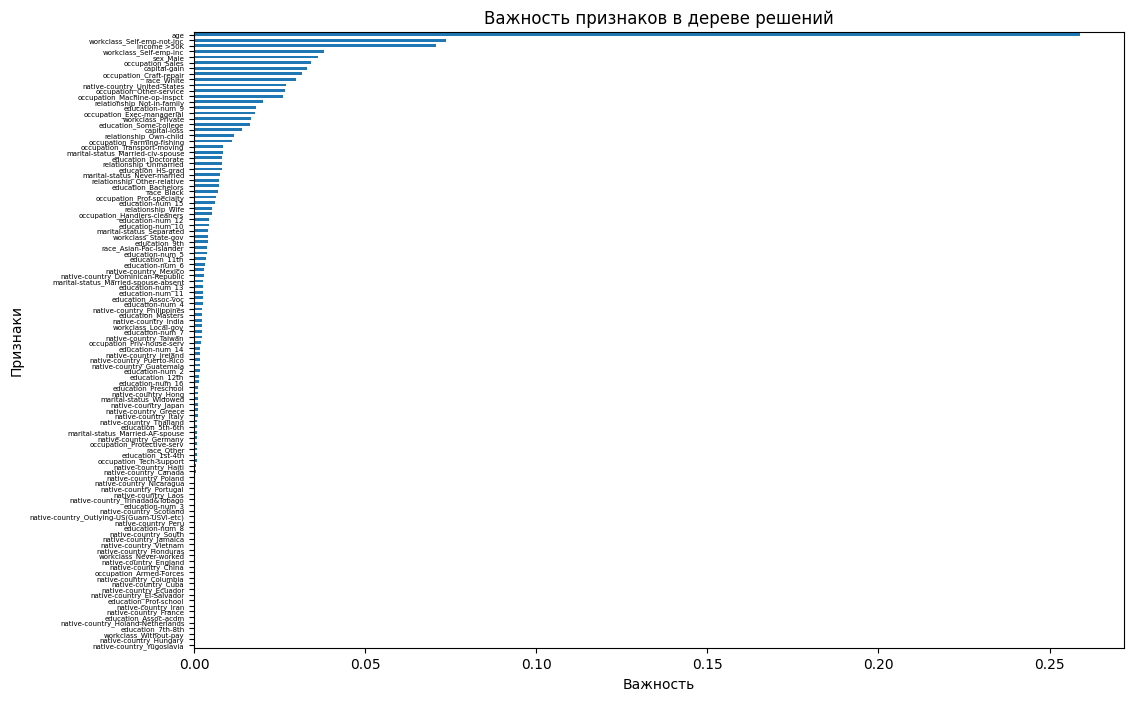

In [34]:
# import matplotlib.pyplot as plt

# feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
# feature_importances.sort_values().plot(kind='barh')
# plt.title('Важность признаков в дереве решений')
# plt.show()

import matplotlib.pyplot as plt
import pandas as pd

# Предполагается, что tree_model уже обучена и X_encoded - это закодированные данные
feature_importances = pd.Series(tree_model.feature_importances_, index=X_encoded.columns)

# Установка размера графика
plt.figure(figsize=(12, 8))  # Увеличение размера графика
feature_importances.sort_values().plot(kind='barh')

# Настройка заголовка и меток
plt.title('Важность признаков в дереве решений')  # Увеличенный шрифт заголовка
plt.xlabel('Важность')  # Увеличенный шрифт метки по оси X
plt.ylabel('Признаки')  # Увеличенный шрифт метки по оси Y

# Настройка меток по оси Y
plt.yticks(fontsize=5)  # Увеличение шрифта для меток оси Y

# Если метки на оси Y длинные, можно их повернуть
plt.yticks(rotation=0)  # Поворот меток на оси Y (по умолчанию горизонтально)

# Показ графика
plt.show()




На этом таблицы видим, что самые важные\значительные являются
age(возраст)>0.25,

workclass_Self-emp-not-inc(рабочий клас_самость_эми_не_инк) ~0.85   

income>50K(доход>50K)~0.75,

workclass_Self-emp-inc(рабочий клас_самость_эми_инк)~0.045,

sex_Male(пол_мужской)~0.035

In [35]:
# from sklearn.tree import plot_tree
# # Визуализируем дерево решений
# plt.figure(figsize=(80, 60))
# plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
# plt.show()

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Получаем количество признаков и классов из дерева
num_features = tree_model.tree_.n_features
num_classes = tree_model.tree_.n_classes

print(f"Количество признаков: {num_features}")
print(f"Количество классов: {num_classes}")

# Визуализируем дерево решений
plt.figure(figsize=(200, 150))  # Уменьшите размер графика до разумных значений
try:
    plot_tree(tree_model,
              feature_names=X.columns[:num_features],  # Убедитесь, что вы используете правильное количество признаков
              class_names=[str(item) for item in sorted(y.unique())],  # Убедитесь, что количество классов совпадает
              filled=True,
              rounded=True)
    plt.show()
except Exception as e:
    print(f"Произошла ошибка: {e}")


Количество признаков: 110
Количество классов: [93]
Произошла ошибка: index 53 is out of bounds for axis 0 with size 27
